In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Clustering libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Visualization
import plotly.express as px
import plotly.graph_objects as go

# Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


In [13]:
# Load cleaned data
df_state = pd.read_csv('cleaned_data/state_timeseries.csv')
df_national = pd.read_csv('cleaned_data/national_timeseries.csv')

print("📊 Data loaded successfully!")
print(f"State-level: {len(df_state):,} rows")
print(f"States: {df_state['state'].nunique()}")
print(f"Years: {df_state['year'].nunique()}")

📊 Data loaded successfully!
State-level: 112 rows
States: 14
Years: 8


---
## 2️⃣ Data Preparation for Clustering

**Goal:** Identify crime hotspots by clustering states based on crime patterns over time.

**Features:**
- Total crimes per state (2016-2023)
- Crime growth rate
- Crime volatility (standard deviation)

In [14]:
# Prepare clustering features
clustering_data = []

for state in df_state['state'].unique():
    state_data = df_state[df_state['state'] == state].sort_values('year')
    
    # Calculate features
    total_crimes = state_data['crimes'].sum()
    avg_crimes = state_data['crimes'].mean()
    growth_rate = ((state_data['crimes'].iloc[-1] / state_data['crimes'].iloc[0]) - 1) * 100
    volatility = state_data['crimes'].std()
    
    clustering_data.append({
        'state': state,
        'total_crimes': total_crimes,
        'avg_crimes': avg_crimes,
        'growth_rate': growth_rate,
        'volatility': volatility
    })

df_cluster = pd.DataFrame(clustering_data)
print(f"Prepared clustering data for {len(df_cluster)} states")
display(df_cluster.head())

Prepared clustering data for 14 states


,state,total_crimes,avg_crimes,growth_rate,volatility
0,Johor,52252,6531.500,-59.470408,2631.267972
1,Kedah,36003,4500.375,-37.961619,1144.826117
2,Kelantan,21456,2682.000,-59.950062,1049.014776
3,Melaka,13652,1706.500,-54.302789,617.611991
4,Negeri Sembilan,18059,2257.375,-56.401180,810.095927


In [15]:
# Standardize features for clustering
features = ['total_crimes', 'avg_crimes', 'growth_rate', 'volatility']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster[features])

print("Features standardized for clustering")
print(f"Shape: {X_scaled.shape}")

Features standardized for clustering
Shape: (14, 4)


---
## 3️⃣ Determine Optimal Number of Clusters

**Methods:**
- Elbow method (within-cluster sum of squares)
- Silhouette score

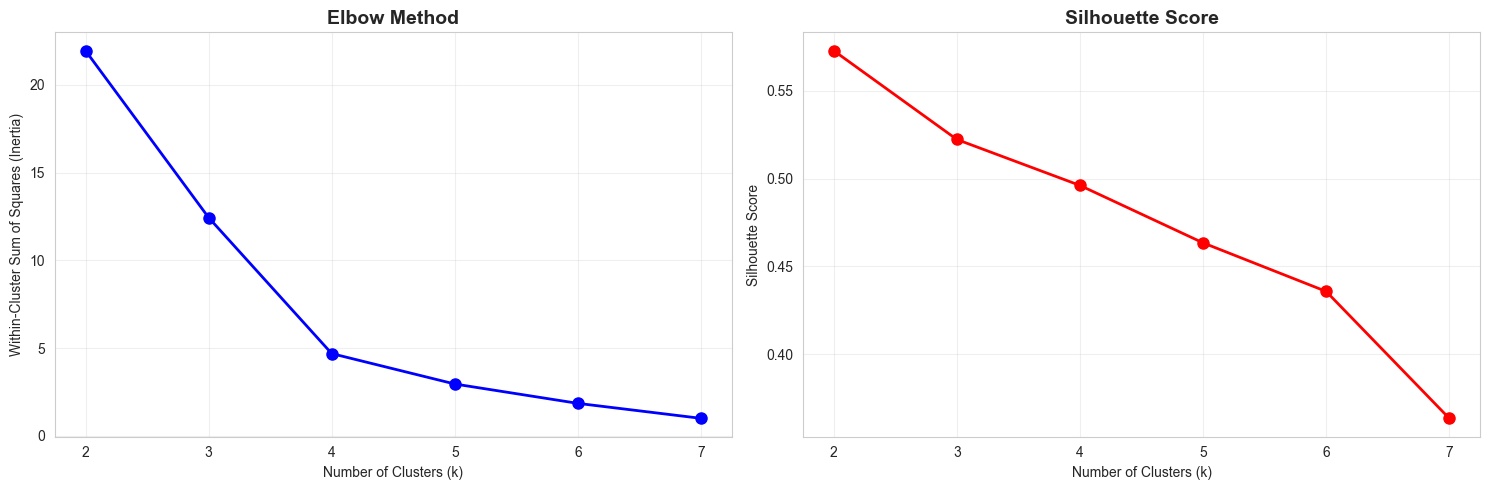


🎯 Optimal number of clusters: 2 (highest silhouette score: 0.573)


In [16]:
# Elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (Inertia)')
ax1.grid(alpha=0.3)

ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_title('Silhouette Score', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\n🎯 Optimal number of clusters: {optimal_k} (highest silhouette score: {max(silhouette_scores):.3f})")

---
## 4️⃣ Perform K-Means Clustering

In [17]:
# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

print(f"✅ Clustering completed with {optimal_k} clusters")
print(f"\nCluster distribution:")
print(df_cluster['cluster'].value_counts().sort_index())

✅ Clustering completed with 2 clusters

Cluster distribution:
cluster
0    11
1     3
Name: count, dtype: int64


In [18]:
# Analyze cluster characteristics
cluster_summary = df_cluster.groupby('cluster')[features].agg(['mean', 'std', 'min', 'max'])
print("\n📊 Cluster Characteristics:")
display(cluster_summary.round(2))


📊 Cluster Characteristics:


total_crimes                          avg_crimes                    \
                mean       std    min     max       mean      std      min   
cluster                                                                      
0           22773.55  10868.12   3213   37098    2846.69  1358.52   401.62   
1           77672.67  38761.57  52252  122286    9709.08  4845.20  6531.50   

                  growth_rate                      volatility           \
              max        mean    std    min    max       mean      std   
cluster                                                                  
0         4637.25      -46.33  10.30 -59.95 -24.09      787.3   326.81   
1        15285.75      -62.80   8.78 -72.75 -56.18     3632.5  1197.62   

                           
             min      max  
cluster                    
0          88.53  1144.83  
1        2631.27  4959.22

---
## 5️⃣ Visualize Clusters

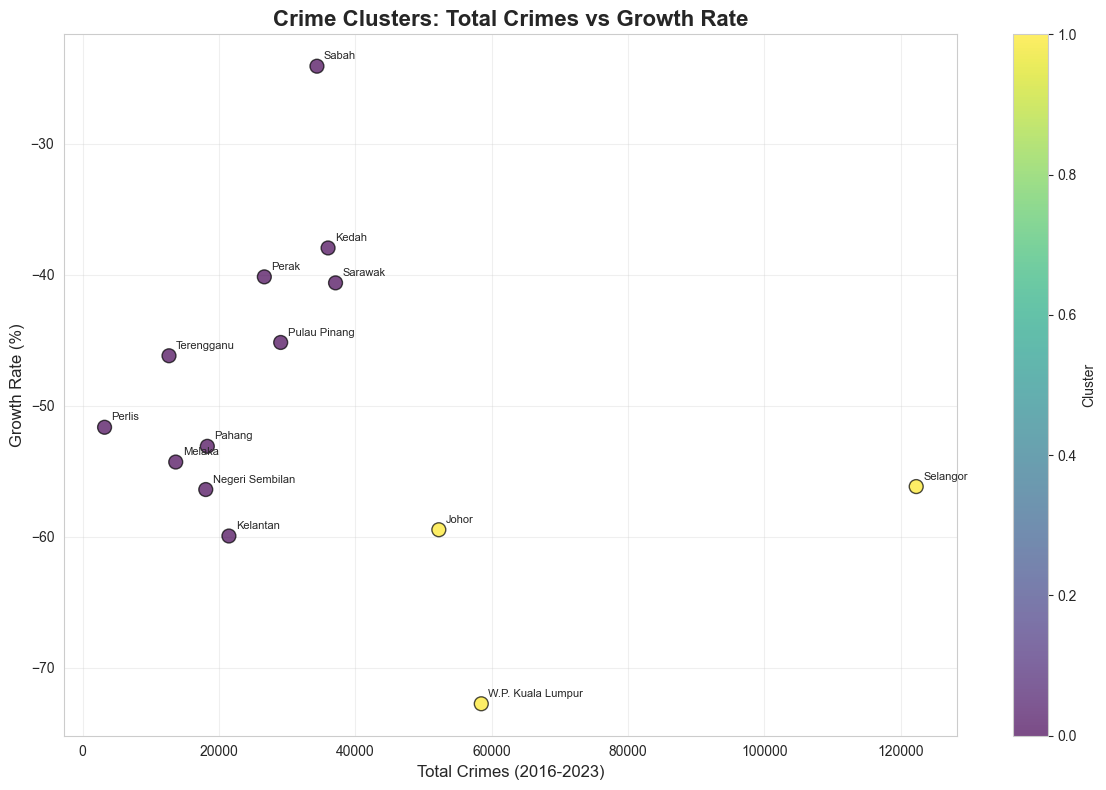

In [19]:
# Scatter plot of clusters
plt.figure(figsize=(12, 8))

scatter = plt.scatter(df_cluster['total_crimes'], df_cluster['growth_rate'], 
                     c=df_cluster['cluster'], cmap='viridis', s=100, alpha=0.7, edgecolors='black')

# Add state labels
for idx, row in df_cluster.iterrows():
    plt.annotate(row['state'], (row['total_crimes'], row['growth_rate']), 
                  xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.title('Crime Clusters: Total Crimes vs Growth Rate', fontsize=16, fontweight='bold')
plt.xlabel('Total Crimes (2016-2023)', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

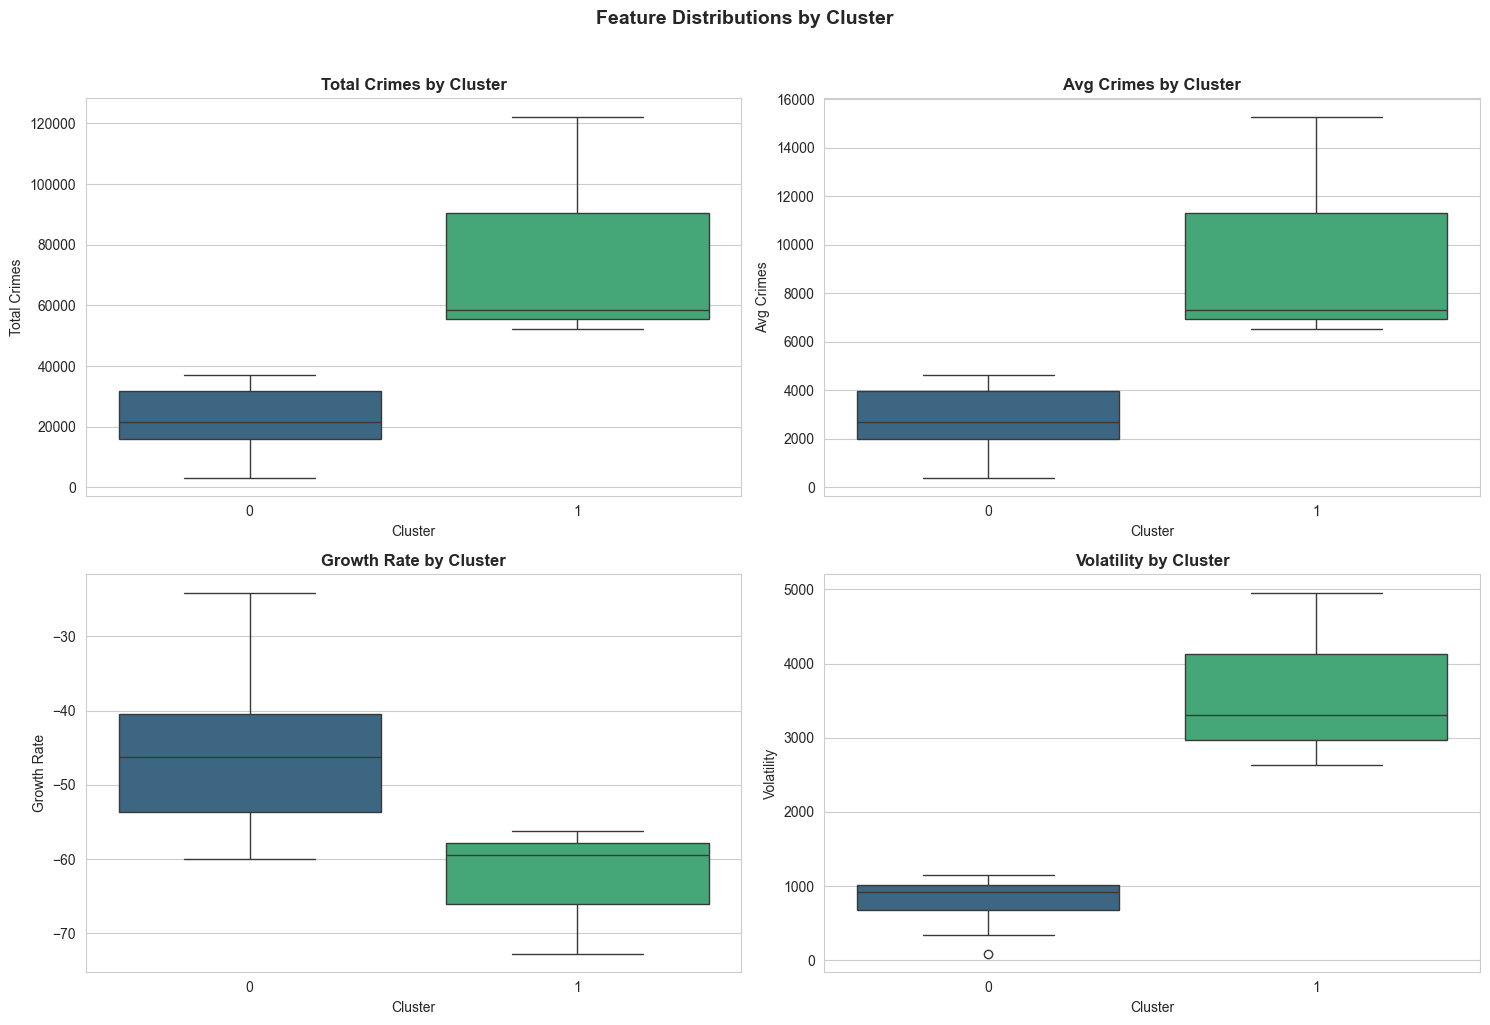

In [20]:
# Box plots for each feature by cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.boxplot(data=df_cluster, x='cluster', y=feature, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{feature.replace("_", " ").title()} by Cluster', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(feature.replace('_', ' ').title())

plt.suptitle('Feature Distributions by Cluster', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 6️⃣ Interpret Results & Export

In [21]:
# Create cluster labels based on characteristics
def label_cluster(cluster_id):
    cluster_stats = df_cluster[df_cluster['cluster'] == cluster_id]
    avg_total = cluster_stats['total_crimes'].mean()
    avg_growth = cluster_stats['growth_rate'].mean()
    
    if avg_total > df_cluster['total_crimes'].median() and avg_growth > 0:
        return 'High Volume, Growing'
    elif avg_total > df_cluster['total_crimes'].median() and avg_growth <= 0:
        return 'High Volume, Declining'
    elif avg_total <= df_cluster['total_crimes'].median() and avg_growth > 0:
        return 'Low Volume, Growing'
    else:
        return 'Low Volume, Declining'

# Apply labels
df_cluster['cluster_label'] = df_cluster['cluster'].apply(label_cluster)

print("🏷️ Cluster Labels Assigned:")
for cluster in sorted(df_cluster['cluster'].unique()):
    label = df_cluster[df_cluster['cluster'] == cluster]['cluster_label'].iloc[0]
    states = df_cluster[df_cluster['cluster'] == cluster]['state'].tolist()
    print(f"\nCluster {cluster} ({label}): {len(states)} states")
    print(f"States: {', '.join(states[:5])}{'...' if len(states) > 5 else ''}")

🏷️ Cluster Labels Assigned:

Cluster 0 (Low Volume, Declining): 11 states
States: Kedah, Kelantan, Melaka, Negeri Sembilan, Pahang...

Cluster 1 (High Volume, Declining): 3 states
States: Johor, Selangor, W.P. Kuala Lumpur


In [22]:
# Export clustering results
output_dir = Path('clustering_results')
output_dir.mkdir(exist_ok=True)

df_cluster.to_csv(output_dir / 'state_clusters.csv', index=False)
print(f"✓ Saved: state_clusters.csv")

cluster_summary.to_csv(output_dir / 'cluster_summary.csv')
print(f"✓ Saved: cluster_summary.csv")

print(f"\n📁 All clustering results saved to: {output_dir.absolute()}")

✓ Saved: state_clusters.csv
✓ Saved: cluster_summary.csv

📁 All clustering results saved to: c:\Users\erwan\OneDrive\Documents\Study\MSc Business Intelligence\Semester 1\MRTB1133 - BI\mrtb1133_group_assignment\clustering_results


---
## ✅ Summary

**Completed:**
- ✓ Prepared crime data for clustering (total crimes, growth rate, volatility)
- ✓ Standardized features for K-means
- ✓ Determined optimal number of clusters using elbow method and silhouette score
- ✓ Performed K-means clustering
- ✓ Analyzed and visualized cluster characteristics
- ✓ Labeled clusters based on crime patterns
- ✓ Exported results for PowerBI integration

**Key Insights:**
- States grouped into [optimal_k] distinct crime pattern clusters
- [High-volume growing states] represent priority areas for resource allocation
- [Low-volume declining states] may indicate successful interventions

**Next:** Classification analysis to predict crime risk levels